## Classification d'extraits sonores

L'objectif de ce TP est de manipuler des données audio, sous plusieurs formes. Nous travaillerons sur une base de données extraite de [VoxLingua](http://bark.phon.ioc.ee/voxlingua107/). Le problème que nous chercherons à résoudre est celui de la **reconnaissance du langage parlé**. Pour simplifier le problème (et le rendre traitable dans le temps du TP), nous nous limiterons à seulement 7 langues, toutes d'origine latine : le français, l'espagnol, le catalan, l'occitan, le portugais, l'italien, et le roumain.

La base de données sur laquelle nous travaillerons contient 200 extraits audio par langue dans la base d'apprentissage, et 30 par langue dans la base de test. Elle vous permettra de prototyper rapidemet vos réseaux, mais induira très certainement **un fort surapprentissage**.

Le traitement du signal audio par apprentissage profond est un vaste domaine, pour lequel il existe de multiples façons de traiter les problèmes. Nous en verrons aujourd'hui 3, qui seront complétées dans quelques semaines par les *transformers*.

Commençons par télécharger les données :


In [ ]:
!git clone https://github.com/axelcarlier/spokenlanguage.git

Cloning into 'spokenlanguage'...
remote: Enumerating objects: 1628, done.
remote: Total 1628 (delta 0), reused 0 (delta 0), pack-reused 1628
Receiving objects: 100% (1628/1628), 416.03 MiB | 34.33 MiB/s, done.
Updating files: 100% (1610/1610), done.


Les données sont chargées dans des variables *x_train*, *x_test*, *y_train* et *y_test*.

In [ ]:
import os
from scipy.io import wavfile
import numpy as np

languages = ['ca', 'es', 'fr', 'it', 'oc', 'pt', 'ro']
nb_images_train = 1400
nb_images_test = 210
sr = 16000

x_train = np.zeros((nb_images_train, 5*sr), dtype='float')
y_train = np.zeros((nb_images_train, len(languages)), dtype='float')
x_test = np.zeros((nb_images_test, 5*sr), dtype='float')
y_test = np.zeros((nb_images_test, len(languages)), dtype='float')

index_train = 0
index_test = 0
for lang in languages:

  lang_index = languages.index(lang)


  for file in os.listdir('/content/spokenlanguage/Train/' + lang + '/'):
    samplerate, data = wavfile.read('/content/spokenlanguage/Train/' + lang + '/' + file)

    x_train[index_train, :min(len(data), 5*16000)] = data[:min(len(data), 5*16000)]
    y_train[index_train, lang_index] = 1
    index_train = index_train + 1

  for file in os.listdir('/content/spokenlanguage/Test/' + lang + '/'):
    samplerate, data = wavfile.read('/content/spokenlanguage/Test/' + lang + '/' + file)

    x_test[index_test, :min(len(data), 5*16000)] = data[:min(len(data), 5*16000)]
    y_test[index_test, lang_index] = 1
    index_test = index_test + 1




Prenez le temps de regarder leur format. Les extraits sont coupés après 5 secondes, et sont complétés avec des '0' (*zero-padding*) lorsqu'ils sont trop courts. Chaque extrait a une fréquence d'échantillonnage de 16000/sec, et chaque donnée est donc réduite (ou étendue) à 80000 échantillons.

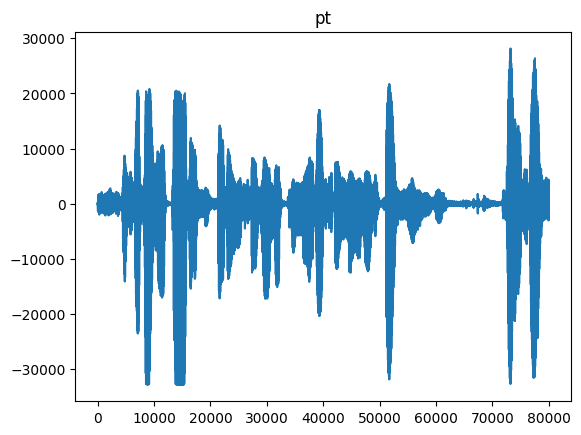

In [ ]:
import matplotlib.pyplot as plt
import random

ind_sample = random.randint(0, x_train.shape[0])

# Affichage du signal 1D d'un des extraits
plt.plot(x_train[ind_sample])
plt.title(languages[np.argmax(y_train[ind_sample])])
plt.show()

## Travail à faire



1.   (**facultatif si vous démarrez par le TP0**) Construisez un premier réseau de neurones, simple, qui permet de classifier les signaux 1D selon les 7 classes (langues). Vous pouvez vous contenter d'une architecture simple (conv1D/pooling) pour obtenir ces premiers  résultats.

  N.B. 1 : **Attention à la normalisation des données !**

  N.B. 2 : **Ne cherchez pas à corriger le surapprentissage !**

  N.B. 3 : **Pour réduire rapidement la dimension des tenseurs, n'hésitez pas à utiliser l'argument dilation_rate de la fonction Conv1D**

2.   Transformez le signal 1D en un log-spectrogramme de Mel, comme présenté ci-dessous dans l'exemple fourni. Vous vous retrouvez devant un problème de classification d'image, que vous pouvez maintenant tenter de résoudre avec des convolutions 2D, et un simple réseau de type VGG.

  N.B. : **Attention à la normalisation des données !**

3.   En dernier recours, testez maintenant une architecture récurrente, comme par exemple un [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/). Vous pouvez considérer un signal audio comme une séquence de vecteurs d'intensités (correspondant à chaque fréquence du spectrogramme de Mel), et lier cette entrée à une (ou plusieurs) couches récurrentes, avant de terminer le réseau par une ou plusieurs couches denses.

  N.B. 1 : **Attention au format des données en entrée d'un LSTM : [batch, timesteps, feature]**

  N.B. 2 : **Attention, le problème est de type *many-to-one*, mais lorsque vous chaînez 2 couches récurrentes, la première doit également retourner une séquence !**

4.   Lorsque toutes vos architectures fonctionneront, vous pourrez les tester sur une base de données plus large. Voici le lien pour les récupérer :
```!git clone https://github.com/axelcarlier/spokenlanguage_large.git```

Attention, les fichiers ne sont plus au format .wav mais au format MP3 (pour gagner de l'espace et tenir sur Github), il vous faudra donc modifier le code de chargement des données. Il y a maintenant 2000 échantillons par classe dans la base de données.

#### 1) Architecture simple (conv1D/pooling)


In [ ]:
# Normalisation
x_train = x_train/80000
x_test = x_test/80000

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Flatten

# Réseau de neurones
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', dilation_rate=3, input_shape=(80000,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', dilation_rate=3))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=96, kernel_size=3, activation='relu', dilation_rate=3))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', dilation_rate=3))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de le connecter à une couche dense
model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(7, activation='softmax'))   # Couche de sortie

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 79994, 32)         128       
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 39997, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 39991, 64)         6208      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 19995, 64)         0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 19989, 96)         18528     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 9994, 96)         

In [ ]:
# Entraînement

from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=10)

Epoch 1/10
140/140 [==============================] - 32s 135ms/step - loss: 0.4300 - accuracy: 0.1429
Epoch 2/10
140/140 [==============================] - 19s 135ms/step - loss: 0.4058 - accuracy: 0.2114
Epoch 3/10
140/140 [==============================] - 19s 136ms/step - loss: 0.3617 - accuracy: 0.3514
Epoch 4/10
140/140 [==============================] - 19s 136ms/step - loss: 0.2061 - accuracy: 0.7079
Epoch 5/10
140/140 [==============================] - 19s 138ms/step - loss: 0.0692 - accuracy: 0.9257
Epoch 6/10
140/140 [==============================] - 19s 137ms/step - loss: 0.0278 - accuracy: 0.9821
Epoch 7/10
140/140 [==============================] - 19s 137ms/step - loss: 0.0112 - accuracy: 0.9943
Epoch 8/10
140/140 [==============================] - 19s 136ms/step - loss: 0.0100 - accuracy: 0.9979
Epoch 9/10
140/140 [==============================] - 19s 136ms/step - loss: 0.0016 - accuracy: 0.9993
Epoch 10/10
140/140 [==============================] - 19s 137ms/step - l

#### 2) Transformation du signal 1D en un log-spectrogramme de Mel et convolution 2D


In [ ]:
import matplotlib.pyplot as plt
import librosa.display

x_train_mel = []
for ind_sample in range (len(x_train)):
  # Calcul du spectrogramme de Mel
  S = librosa.feature.melspectrogram(y=x_train[ind_sample])

  # Passage en échelle logarithmique des énergies, pour mieux discerner le signal.
  S_dB = librosa.power_to_db(S, ref=np.max)

  # Ajout de la valeur normalisée
  x_train_mel.append((S_dB+80)/80)

In [ ]:
x_train_mel = np.array(x_train_mel)

In [ ]:
x_test_mel = []
for ind_sample in range (len(x_test)):
  # Calcul du spectrogramme de Mel
  S = librosa.feature.melspectrogram(y=x_test[ind_sample])

  # Passage en échelle logarithmique des énergies, pour mieux discerner le signal.
  S_dB = librosa.power_to_db(S, ref=np.max)

  # Ajout de la valeur normalisée
  x_test_mel.append((S_dB+80)/80)

x_test_mel = np.array(x_test_mel)

In [ ]:
_, input, seq = np.shape(x_train_mel)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(input, seq, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de le connecter à une couche dense
model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(7, activation='softmax'))   # Couche de sortie

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 155, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 77, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 35, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 17, 96)        0

In [ ]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train_mel, y_train, validation_data=(x_test_mel, y_test), epochs=30, batch_size=30)

Epoch 1/30
47/47 [==============================] - 18s 60ms/step - loss: 0.4438 - accuracy: 0.1321 - val_loss: 0.4123 - val_accuracy: 0.1429
Epoch 2/30
47/47 [==============================] - 1s 20ms/step - loss: 0.4127 - accuracy: 0.1443 - val_loss: 0.4111 - val_accuracy: 0.1762
Epoch 3/30
47/47 [==============================] - 1s 18ms/step - loss: 0.4121 - accuracy: 0.1500 - val_loss: 0.4082 - val_accuracy: 0.1905
Epoch 4/30
47/47 [==============================] - 1s 19ms/step - loss: 0.4094 - accuracy: 0.1607 - val_loss: 0.4079 - val_accuracy: 0.1524
Epoch 5/30
47/47 [==============================] - 1s 18ms/step - loss: 0.4079 - accuracy: 0.1729 - val_loss: 0.4077 - val_accuracy: 0.2000
Epoch 6/30
47/47 [==============================] - 1s 18ms/step - loss: 0.4067 - accuracy: 0.1907 - val_loss: 0.4083 - val_accuracy: 0.1381
Epoch 7/30
47/47 [==============================] - 1s 18ms/step - loss: 0.4046 - accuracy: 0.2107 - val_loss: 0.4076 - val_accuracy: 0.1905
Epoch 8/30
4

In [ ]:
def plot_training_analysis():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

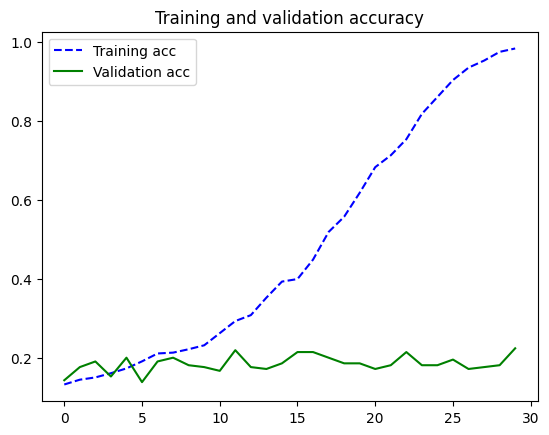

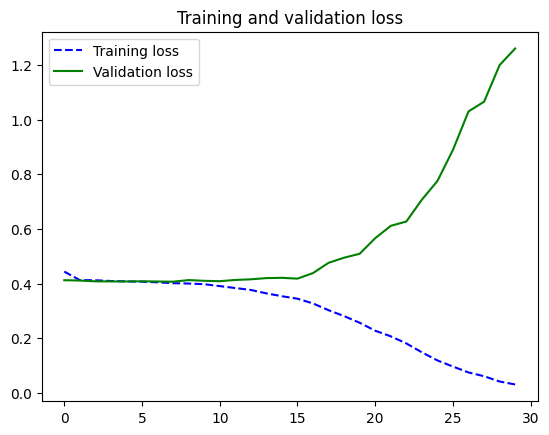

In [ ]:
plot_training_analysis()

####3) Architecture récurrente, LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()

model.add(LSTM(64, input_shape=(128, 157), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(x_train_mel, y_train, validation_data=(x_test_mel, y_test), epochs=30, batch_size=30)

## Spectrogramme de Mel

Le spectrogramme de Mel est une représentation temps/fréquence, comme le sonagramme que vous avez vu l'an passé, pour laquelle l'échelle des fréquences est adaptée à la perception humaine. C'est une représentation classique en traitement de la parole.

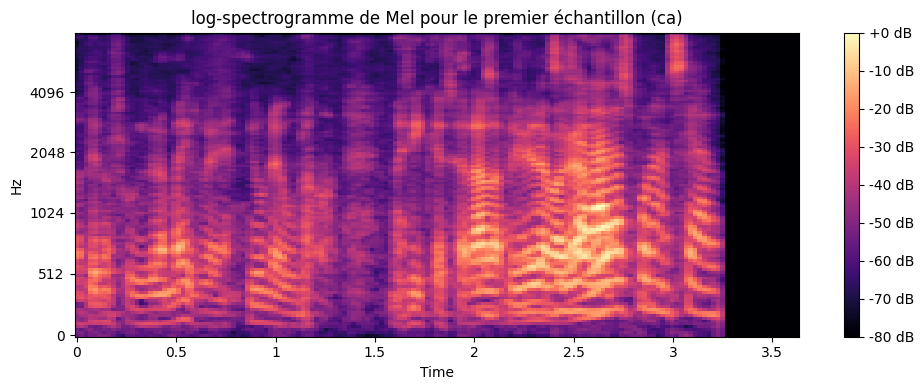

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

# Calcul du spectrogramme de Mel
S = librosa.feature.melspectrogram(y=x_train[0])

plt.figure(figsize=(10, 4))
# Passage en échelle logarithmique des énergies, pour mieux discerner le signal.
S_dB = librosa.power_to_db(S, ref=np.max)

# Affichage du résultat
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('log-spectrogramme de Mel pour le premier échantillon (' + languages[np.argmax(y_train[0])] + ')' )
plt.tight_layout()
plt.show()